In [1]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./trajopt/constraint.jl")
include("./trajopt/costfunction.jl")
include("./trajopt/scaling.jl")
include("./trajopt/scp.jl")
include("./trajopt/discretize.jl")
using Plots

In [2]:
ix = 12
iu = 4
N = 10
dynamics = QuadrotorDynamics()
g = dynamics.g
m = dynamics.m

1.0

In [43]:
frequency = 2*pi/20
function position_control(t::Float64,x::Vector)
    N = x[1]
    E = x[2]
    D = x[3]

    vN = x[4]
    vE = x[5]
    vD = x[6]

    phi = x[7]
    theta = x[8]
    psi = x[9]

    p = x[10]
    q = x[11]
    r = x[12]

    att_dot = zeros(3)
    att_dot[1] = p + q*sin(phi)*tan(theta) + r*cos(phi)*tan(theta)
    att_dot[2] = q*cos(phi) - r*sin(phi)
    att_dot[3] = q*sin(phi)/cos(theta) + r*cos(phi)/cos(theta)

    # desired position (hard coding)
    Ddes = - 5.0
    Ddes_dot = 0.0
    Ndes = 2 * cos(frequency*t)
    Ndes_dot = - 2 * frequency * sin(frequency*t)
    Ndes_ddot = - 2 * frequency^2 * cos(frequency*t)
    Edes = 2 * sin(frequency*t)
    Edes_dot = 2 * frequency * cos(frequency*t)
    Edes_ddot = - 2 * frequency^2 * sin(frequency*t)

    psi_des = deg2rad(10)
    psi_des_dot = 0.0

    # convert desired position into desired attitude
    a = 2e-1 * 1
    b = 1e-1 * 1
    c = 1e-1
    phi_des = - (b * (Edes - E) + a * (Edes_dot - vE) + c * Edes_ddot)
    theta_des = - (b * (Ndes - N) + a * (Ndes_dot - vN) + c * Ndes_ddot)

    convert = [cos(psi) sin(psi);sin(psi) -cos(psi)] * [theta_des; phi_des]
    theta_des = convert[1]
    phi_des = convert[2]

    tmp = 0.1
    if abs(theta_des)+abs(phi_des) > tmp
        theta_des = theta_des / sqrt(theta_des^2+phi_des^2) * tmp;
        phi_des = phi_des / sqrt(theta_des^2+phi_des^2) * tmp;
    end
    

    att_des = [phi_des,theta_des,psi_des]
    att_des_dot = [0,0,psi_des_dot]

    att_err = att_des - x[7:9]
    att_err_dot = att_des_dot - att_dot

    # total thrust
    kp_z = 5.0
    kd_z = 10.0
    Fz = - 1 / (cos(phi)*cos(theta)) * (kp_z * (Ddes - D) + kd_z * (Ddes_dot - vD)) + m*g

    return Fz,att_err,att_err_dot
end

function attitude_control(t::Float64,x::Vector,att_err::Vector,att_err_dot::Vector)
    att_err_int = x[ix+1:ix+3]
    kp = Diagonal([100.0,100.0,5.0])
    ki = 10.0 * Diagonal([1.0,1.0,0.1])
    kd = Diagonal([40.0,30.0,5.0])
    M = kp * att_err + ki * att_err_int + kd * att_err_dot
    return M
end

function control_systems!(f,x,p,t)
    dt = p[1]
    state = x[1:12]

    # position control
    Fz,att_err,att_err_dot = position_control(dt*t,x)

    # attitude_control
    M = attitude_control(dt*t,x,att_err,att_err_dot)

    control_input = zeros(iu)
    control_input[1] = Fz
    control_input[2:end] = M

    f[1:ix] .= dt*forward(dynamics,state,control_input)
    f[ix+1:ix+3] .= dt*att_err
end

control_systems! (generic function with 1 method)

In [44]:
tspan = (0,1)
saveat = collect(range(0,1,501))
x0 = [0.;0.;0.; 0.;0.;0.; 0.;0.;0.; 0.;0.;0.;
        0.;0.;0. # attiude error integration
        ]
T = 30
prob = ODEProblem(control_systems!,x0,tspan,(T))
sol = solve(prob, Tsit5(),saveat=saveat,reltol=1e-9, abstol=1e-9;verbose=false);
tode = sol.t
xode = stack(sol.u)
tplot = T .* tode

501-element Vector{Float64}:
  0.0
  0.06
  0.12
  0.18
  0.24
  0.3
  0.36
  0.42
  0.48
  0.5399999999999999
  ⋮
 29.52
 29.58
 29.64
 29.7
 29.759999999999998
 29.82
 29.88
 29.94
 30.0

In [45]:
Ndes = 2 .* cos.(frequency.*tplot)
Edes = 2 .* sin.(frequency.*tplot);

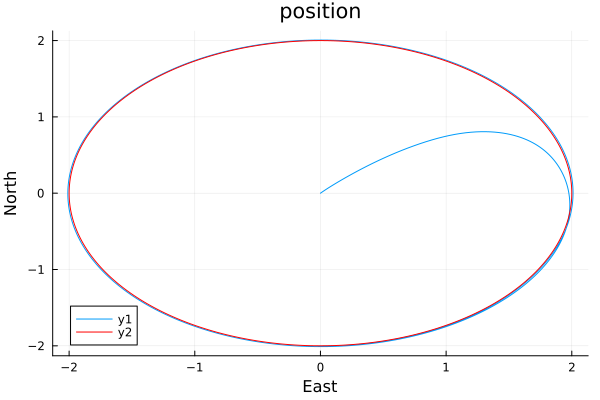

In [46]:
plot(xode[2,:],xode[1,:],title="position")
plot!(Edes,Ndes,color=:red)
xlabel!("East")
ylabel!("North")

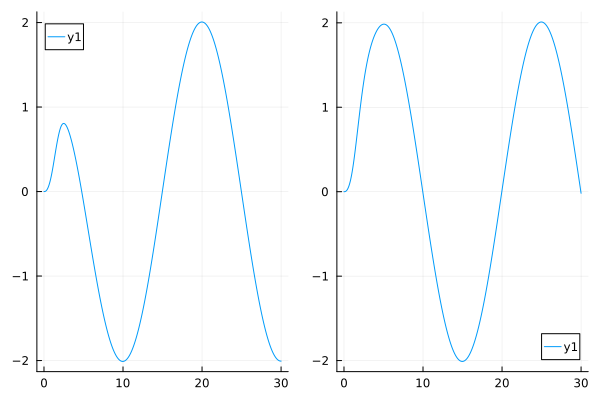

In [47]:
px = plot(tplot,xode[1,:])
py = plot(tplot,xode[2,:])
plot(px,py)

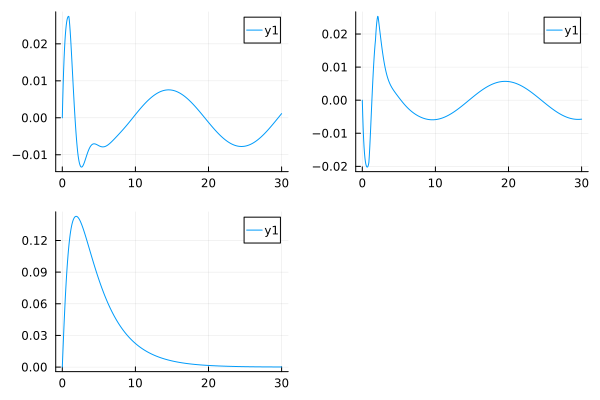

In [48]:
p1 = plot(tplot,xode[13,:])
p2 = plot(tplot,xode[14,:])
p3 = plot(tplot,xode[15,:])
plot(p1,p2,p3)

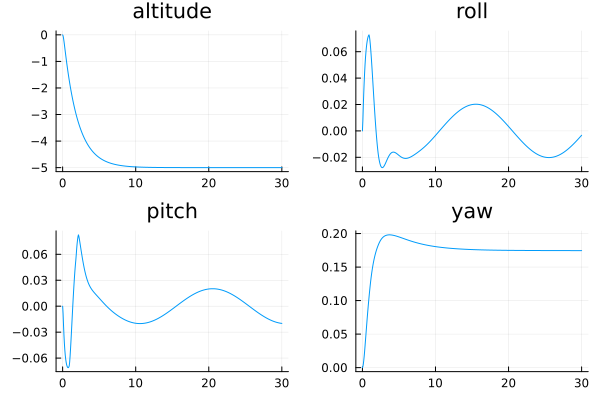

In [49]:
pz = plot(tplot,xode[3,:],title="altitude")

p_phi = plot(tplot,xode[7,:],title="roll")
p_theta = plot(tplot,xode[8,:],title="pitch")
p_psi = plot(tplot,xode[9,:],title="yaw")
plot(pz, p_phi, p_theta, p_psi, layout = (2, 2), legend = false)

In [50]:
anim = Animation()

Animation("/var/folders/zh/8dk8mcb12vs7vp_rqg6sj_780000gn/T/jl_kD9fTM", String[])

In [51]:
for idx in 1:length(tplot)
    plot(xode[2,1:idx],xode[1,1:idx],label="quadrotor",title="position",aspect_ratio=1,size=(500,500))
    plot!(Edes[1:idx],Ndes[1:idx],color=:red,label="desired")
    scatter!([xode[2,idx]],[xode[1,idx]],makershape=:circle,markersize=5,color=:blue,label="")
    scatter!([Edes[idx]],[Ndes[idx]],makershape=:circle,markersize=5,color=:red,label="")
    xlims!(-2.5, 2.5)
    ylims!(-2.5, 2.5)
    xlabel!("East")
    ylabel!("North")
    frame(anim)
end

┌ Info: Saved animation to /Users/taewankim/Documents/Code/Personal/Funnel_CTCS/data_image/PID_quadrotor.gif
└ @ Plots /Users/taewankim/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/taewankim/Documents/Code/Personal/Funnel_CTCS/data_image/PID_quadrotor.gif")
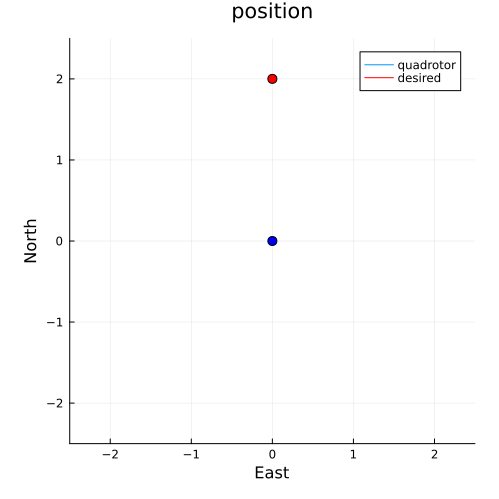

In [52]:
gif(anim, "./data_image/PID_quadrotor.gif", fps=1/tplot[2])

In [ ]:
1/tplot[2]